In [57]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

In [58]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [59]:
Train_data = "C:/Users/gaura/Pictures/PV-Module-Fault-Detection/data/"
Test_data = "C:/Users/gaura/Pictures/PV-Module-Fault-Detection/test/"

train_data_df = pd.DataFrame(columns=['Image_path','Label'])
test_data_df = pd.DataFrame(columns=['Image_path'])

In [60]:
def load_dataframe(DF,path):
    labels_files = os.listdir(Train_data)
    image_paths = []
    labels = []
    for file in labels_files:
        path_file = path + file +'/'
        list_files = os.listdir(path_file)
        for image_path in list_files:
            image_paths.append(path_file + image_path)
            labels.append(file)
    DF['Image_path'] = image_paths
    DF['Label'] = labels
    return(DF)

In [61]:
train_data_df = load_dataframe(train_data_df,Train_data)

labels_files = os.listdir(Test_data)
image_paths = []
labels = []
for file in labels_files:
    path_file = Test_data + file +'\\'
list_files = os.listdir(Test_data)
for image_path in list_files:
  image_paths.append(path_file + image_path)

test_data_df['Image_path'] = image_path 

train_data_df = shuffle(train_data_df)
test_data_df = shuffle(test_data_df)

encoder = LabelEncoder()
train_data_df['Label'] = encoder.fit_transform(train_data_df['Label'])
# test_data_df['Label'] = encoder.fit_transform(test_data_df['Label'])

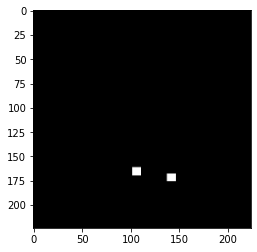

(224, 224, 3)

In [62]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    img = cv2.resize(img,(224,224))
    return img

img = load_image(train_data_df['Image_path'][0])
fig,ax = plt.subplots(1)
ax.imshow(img)
plt.show()

img.shape

In [63]:
x_train = []
for image_path in train_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_train.append(img)
x_train = np.array(x_train)

In [64]:
x_test = []
for image_path in test_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_test.append(img)
x_test = np.array(x_test)

In [65]:
y_train = train_data_df['Label'].to_list()
# y_test = test_data_df['Label'].to_list()

In [66]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=3)
y_train = y_train.reshape(y_train.shape[0],1,1,y_train.shape[1])
# y_test = to_categorical(y_test,num_classes=3)
# y_test = y_test.reshape(y_test.shape[0],1,1,y_test.shape[1])

In [67]:
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,Dropout,Dense,MaxPool2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = tensorflow.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable    

    x =  model.output
    x = Conv2D(512, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dense(3,activation = 'softmax')(x)
    return(Model(inputs = model.input,outputs = x))

In [68]:
model = create_model(False)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [69]:
import tensorflow
Optimizer = tensorflow.keras.optimizers.Adam(learning_rate = 1e-6,beta_1 = 0.9,decay = 1e-5)
model.compile(optimizer= Optimizer,loss= 'categorical_crossentropy',metrics= 'accuracy')

In [70]:
# EarlyStopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta = 0.01)
# # Model Checkpoint
# ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint("VGG-{val_loss:.3f}.h5",monitor='val_loss',save_best_only= True,save_weights_only=True)

In [73]:
# model_history = model.fit(x_train,y_train,epochs = 10,batch_size = 1,validation_data = (x_test),callbacks=[ModelCheckpoint,EarlyStopping])

model_history = model.fit(x_train,y_train, validation_data=x_test,epochs=10,batch_size = 1)

Epoch 1/10
2093/2093 [==============================] - 505s 241ms/step - loss: 0.9016 - accuracy: 0.6106
Epoch 2/10
2093/2093 [==============================] - 501s 239ms/step - loss: 0.8107 - accuracy: 0.6493
Epoch 3/10
2093/2093 [==============================] - 501s 240ms/step - loss: 0.7452 - accuracy: 0.7339
Epoch 4/10
2093/2093 [==============================] - 501s 239ms/step - loss: 0.6887 - accuracy: 0.7530
Epoch 5/10
2093/2093 [==============================] - 501s 239ms/step - loss: 0.6435 - accuracy: 0.8141
Epoch 6/10
2093/2093 [==============================] - 497s 238ms/step - loss: 0.6067 - accuracy: 0.8199
Epoch 7/10
2093/2093 [==============================] - 496s 237ms/step - loss: 0.5730 - accuracy: 0.8309
Epoch 8/10
2093/2093 [==============================] - 497s 238ms/step - loss: 0.5430 - accuracy: 0.8471
Epoch 9/10
2093/2093 [==============================] - 566s 270ms/step - loss: 0.5147 - accuracy: 0.8624
Epoch 10/10
2093/2093 [=======================

In [76]:
def plotModelAccuracy(history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

KeyError: 'val_accuracy'

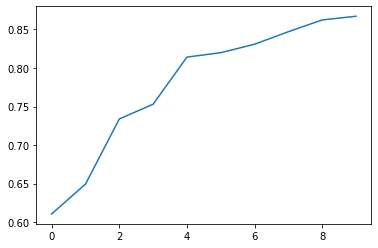

In [77]:
plotModelAccuracy(model_history, 'VGG16')

In [ ]:
#model.save('C:\\Users\\Kalpesh\\Great lakes\\Object Detection')

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['validation_accuracy'])
plt.title("VGG16" +' model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#_model = create_model(True)
#_model.load_weights('pneu_2-0.628.h5')
print(model_history.history.keys())

In [ ]:
#np.array(x_train[20,:,:,:]).reshape(1,224,224,3)

In [ ]:
pred = model.predict(np.array(x_train[120,:,:,:]).reshape(1,224,224,3))

In [ ]:
#model_history = self._model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))

In [ ]:
def plotModelAccuracy(self, history, modelname):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title(modelname+' model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title(modelname+' model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

In [ ]:
encoder.classes_[np.argmax(pred)]

In [ ]:
encoder.classes_[np.argmax(y_train[120][0][0])]

In [ ]:
#import os
#import tensorflow as tf
#import pandas as pd
#import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.utils import shuffle
#import cv2
#import matplotlib.pyplot as plt
#from tensorflow.keras.applications.mobilenet import preprocess_input
#from myhdl import *

#def predict(image):
 #   
  #  _model = create_model(True)
   # _model.load_weights('pneu_2-0.628.h5')
    #image = cv2.resize(image, (224,224))
    #pred = _model.predict(np.array(image).reshape(1,224,224,3))
    #lab = encoder.classes_[np.argmax(pred)]
    #return(lab)

In [ ]:
#image = cv2.imread('D:\\Omkar Project\\chest_xray\\train\\normal\\IM-0191-0001.jpeg', 1)
#predict(image)

In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(_model) # path to the SavedModel directory
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#tflite_model = converter.convert()
#with open('mobnet_model1.tflite', 'wb') as f:
#    f.write(tflite_model)